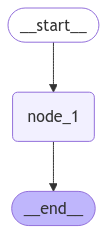

In [2]:
from typing import TypedDict
from langgraph.graph import StateGraph, START, END
from IPython.display import Image, display

class State(TypedDict):
    foo: int

def node_1(state):
    print("---Node1---")
    return {"foo" : state["foo"] + 1}

workflow = StateGraph(State)

workflow.add_node("node_1", node_1)
workflow.add_edge(START, "node_1")
workflow.add_edge("node_1", END)

graph = workflow.compile()

display(Image(graph.get_graph().draw_mermaid_png()))

In [4]:
result = graph.invoke({"foo" : 1})
print(result)

---Node1---
{'foo': 2}


# Branching

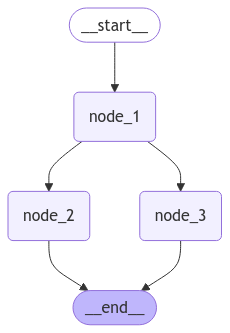

In [5]:
class State(TypedDict):
    foo: int

def node_1(state):
    print("---Node1---")
    return {"foo" : state["foo"] + 1}

def node_2(state):
    print("---Node2---")
    return {"foo" : state["foo"] + 1}

def node_3(state):
    print("---Node3---")
    return {"foo" : state["foo"] + 1}


workflow = StateGraph(State)

workflow.add_node("node_1", node_1)
workflow.add_node("node_2", node_2)
workflow.add_node("node_3", node_3)

workflow.add_edge(START, "node_1")
workflow.add_edge("node_1", "node_2")
workflow.add_edge("node_1", "node_3")
workflow.add_edge("node_2", END)
workflow.add_edge("node_3", END)

graph = workflow.compile()

display(Image(graph.get_graph().draw_mermaid_png()))



In [7]:
from langgraph.errors import InvalidUpdateError

try:
    result = graph.invoke({"foo" : 1})
except InvalidUpdateError as e:
    print(e)


---Node1---
---Node2---
---Node3---
At key 'foo': Can receive only one value per step. Use an Annotated key to handle multiple values.
For troubleshooting, visit: https://python.langchain.com/docs/troubleshooting/errors/INVALID_CONCURRENT_GRAPH_UPDATE


# Reducers

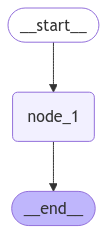

In [10]:
from operator import add
from typing import Annotated

class State(TypedDict):
    foo: Annotated[list[int], add]

def node_1(state):
    print("---Node1---")
    return {"foo" : [state["foo"][-1] + 1]}

workflow = StateGraph(State)

workflow.add_node("node_1", node_1)
workflow.add_edge(START, "node_1")
workflow.add_edge("node_1", END)

graph = workflow.compile()

display(Image(graph.get_graph().draw_mermaid_png()))



In [12]:
result = graph.invoke({"foo" : [1,2]})
print(result)

---Node1---
{'foo': [1, 2, 3]}


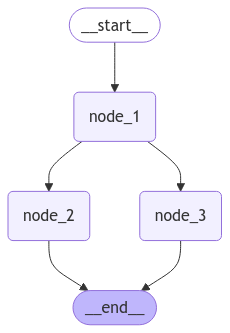

In [13]:
def node_2(state):
    print("---Node2---")
    return {"foo" : [state["foo"][-1] + 1]}

def node_3(state):
    print("---Node3---")
    return {"foo" : [state["foo"][-1] + 1]} 

workflow = StateGraph(State)
workflow.add_node("node_1", node_1)
workflow.add_node("node_2", node_2)
workflow.add_node("node_3", node_3)

workflow.add_edge(START, "node_1")
workflow.add_edge("node_1", "node_2")
workflow.add_edge("node_1", "node_3")
workflow.add_edge("node_2", END)
workflow.add_edge("node_3", END)

graph = workflow.compile()

display(Image(graph.get_graph().draw_mermaid_png()))

In [17]:
result = graph.invoke({"foo" : [1]})
print(result)

---Node1---
---Node2---
---Node3---
{'foo': [1, 2, 3, 3]}


passin None to foo, will get an error

In [19]:
try:
    result = graph.invoke({"foo" : None})
except TypeError as e:
    print(e)

can only concatenate list (not "NoneType") to list


# Custom Reducers

In [30]:
def reduce_list(left: list | None, right: list | None) -> list:
    """Saefly combines two lisrs, handling cases where either or both inputs might be None
    
    Args:
        left (list | None): The left list to combine, or None if the left input is missing
        right (list | None): The right list to combine, or None if the right input is missing
        
    Returns:
        list: The combined list, or an empty list if both inputs are None,
    """
    if not left:
        left = []
    if not right:
        right = []
    return left + right

class DefaultState(TypedDict):
    foo: Annotated[list[int], add]

class CustomReducerState(TypedDict):
    foo: Annotated[list[int], reduce_list]


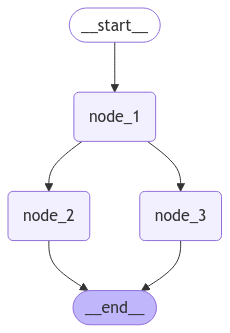

In [68]:
def node_1(state):
    print("---Node1---")
    x = state.get("foo", "")
    print(x)
    return {"foo" : [x[-1] + 1]}

def node_2(state):
    print("---Node2---")
    x = state.get("foo", "")
    return {"foo" : [x[-1] + 1]} 

def node_3(state):
    print("---Node3---")
    x = state.get("foo", "")
    return {"foo" : [x[-1] + 1]} 

workflow1 = StateGraph(DefaultState)
workflow1.add_node("node_1", node_1)
workflow1.add_node("node_2", node_2)
workflow1.add_node("node_3", node_3)

workflow1.add_edge(START, "node_1")
workflow1.add_edge("node_1", "node_2")
workflow1.add_edge("node_1", "node_3")
workflow1.add_edge("node_2", END)
workflow1.add_edge("node_3", END)

graph1 = workflow.compile()

display(Image(graph1.get_graph().draw_mermaid_png()))




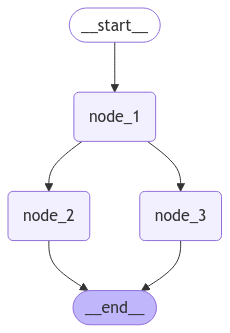

In [69]:
workflow2 = StateGraph(CustomReducerState)
workflow2.add_node("node_1", node_1)
workflow2.add_node("node_2", node_2)
workflow2.add_node("node_3", node_3)

workflow2.add_edge(START, "node_1")
workflow2.add_edge("node_1", "node_2")
workflow2.add_edge("node_1", "node_3")
workflow2.add_edge("node_2", END)
workflow2.add_edge("node_3", END)

graph2 = workflow2.compile()

display(Image(graph2.get_graph().draw_mermaid_png()))

In [59]:
result = graph1.invoke({"foo" : [1,2,3]})
print(result)

---Node1---
---Node2---
---Node3---
{'foo': [1, 2, 3, 4, 5, 5]}


In [60]:
try:
    result = graph1.invoke({"foo" : None})
except TypeError as e:
    print(e)

can only concatenate list (not "NoneType") to list


In [70]:
result = graph2.invoke({"foo" : [1]})
print(result)

---Node1---
[1]
---Node2---
---Node3---
{'foo': [1, 2, 3, 3]}


In [71]:
try:
    result = graph2.invoke({"foo" : None})
except TypeError as e:
    print(e)


---Node1---
[]


IndexError: list index out of range

# Messages Rewriting and Removal

In [42]:
from langgraph.graph.message import add_messages
from langchain_core.messages import AIMessage, HumanMessage


init_message = [AIMessage(content="Hello, how can I help you today?", name="Model"),
                HumanMessage(content="I'm fine, thank you!, I want to know more about marine biology", name="Hrithik"),
                AIMessage(content="What would you like to know about marine biology?", name="Model"),
                HumanMessage(content="I want to know about the different types of marine animals", name="Hrithik")]

new_message = AIMessage(content="Sure, I can help you with that. What type of marine animals are you interested in? ", name="Model")


add_messages(init_message, new_message)





[AIMessage(content='Hello, how can I help you today?', additional_kwargs={}, response_metadata={}, name='Model', id='7d3ae2c4-dcb7-4a36-9dd8-e258a6f029a3'),
 HumanMessage(content="I'm fine, thank you!, I want to know more about marine biology", additional_kwargs={}, response_metadata={}, name='Hrithik', id='2b4a2407-3370-45b9-b3cb-ae1597288150'),
 AIMessage(content='What would you like to know about marine biology?', additional_kwargs={}, response_metadata={}, name='Model', id='b48b6204-533a-45b6-861e-d05b70fcf746'),
 HumanMessage(content='I want to know about the different types of marine animals', additional_kwargs={}, response_metadata={}, name='Hrithik', id='f2b2d22e-79d8-4ff3-9860-5896b3cb9ded'),
 AIMessage(content='Sure, I can help you with that. What type of marine animals are you interested in? ', additional_kwargs={}, response_metadata={}, name='Model', id='9236edfa-b0f2-4bff-bdc1-3970a01da128')]

In [44]:
init_message = [AIMessage(content="Hello, how can I help you today?", name="Model", id="1"),
                HumanMessage(content="I'm fine, thank you!, I want to know more about marine biology", name="Hrithik", id="2"),
                AIMessage(content="What would you like to know about marine biology?", name="Model", id="3"),
                HumanMessage(content="I want to know about the different types of marine animals", name="Hrithik", id="4")]


new_message = HumanMessage(content="I want to know about the Whales", name="Hrithik", id="4")

add_messages(init_message, new_message)

[AIMessage(content='Hello, how can I help you today?', additional_kwargs={}, response_metadata={}, name='Model', id='1'),
 HumanMessage(content="I'm fine, thank you!, I want to know more about marine biology", additional_kwargs={}, response_metadata={}, name='Hrithik', id='2'),
 AIMessage(content='What would you like to know about marine biology?', additional_kwargs={}, response_metadata={}, name='Model', id='3'),
 HumanMessage(content='I want to know about the Whales', additional_kwargs={}, response_metadata={}, name='Hrithik', id='4')]

In [50]:
from langchain_core.messages import RemoveMessage

messages = [AIMessage(content="Hello, how can I help you today?", name="Model", id="1"),
                HumanMessage(content="I'm fine, thank you!, I want to know more about marine biology", name="Hrithik", id="2"),
                AIMessage(content="What would you like to know about marine biology?", name="Model", id="3"),
                HumanMessage(content="I want to know about the different types of marine animals", name="Hrithik", id="4")]

msg_to_remove = messages[:-2]
for msg in msg_to_remove:
    print(msg)

content='Hello, how can I help you today?' additional_kwargs={} response_metadata={} name='Model' id='1'
content="I'm fine, thank you!, I want to know more about marine biology" additional_kwargs={} response_metadata={} name='Hrithik' id='2'


In [51]:
delete_messages = [RemoveMessage(id=m.id) for m in msg_to_remove]
print(delete_messages)

[RemoveMessage(content='', additional_kwargs={}, response_metadata={}, id='1'), RemoveMessage(content='', additional_kwargs={}, response_metadata={}, id='2')]


In [52]:
add_messages(messages, delete_messages)

[AIMessage(content='What would you like to know about marine biology?', additional_kwargs={}, response_metadata={}, name='Model', id='3'),
 HumanMessage(content='I want to know about the different types of marine animals', additional_kwargs={}, response_metadata={}, name='Hrithik', id='4')]